In [68]:
import os
import sys
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import matplotlib.dates as mdates
from shapely.geometry import Point
from sklearn.metrics import r2_score, mean_absolute_error
from geopy.distance import geodesic

### change directory to import more scripts
sys.path.append(str(Path().resolve().parents[0]))

from utils import tools
import generate_wind

if os.getcwd().split(os.sep)[-1] == 'evaluation':
    os.chdir('..')

In [113]:
config = tools.load_config("config.yaml")

val_dir = 'data/Trianel_Benchmark'
synth_dir = os.path.join(config['data']['synth_dir'], 'wind', 'real_parks')
locations_dir = os.path.join(config['data']['synth_dir'], 'wind', 'noage')
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)
results_dir = 'results/real_parks'
geojsn_dir = 'misc/geoBoundaries-DE.geojson'
os.makedirs(results_dir, exist_ok=True)

features = config['features']

params = config['wind_params']

In [ ]:
files = os.listdir(synth_dir)
station_files_synthetic = [f for f in files if 'parameter' not in f and f.endswith('.csv')]
station_files_synthetic.sort()
print(len(station_files_synthetic), 'station files in synthetic data found')
turbine_params = pd.read_csv(os.path.join(synth_dir, 'turbine_parameter.csv'), sep=';')
wind_params = pd.read_csv(os.path.join(synth_dir, 'wind_parameter.csv'), sep=';', dtype={"park_id": str})
all_wind_params = pd.read_csv(os.path.join(locations_dir, 'wind_parameter.csv'), sep=';', dtype={"park_id": str})

2 station files in synthetic data found


In [115]:
timestamp_col = 'timestamp'
dfs = []
for st in station_files_synthetic:
    station = pd.read_csv(os.path.join(synth_dir, st), sep=';')
    station[timestamp_col] = pd.to_datetime(station[timestamp_col], utc=True)
    station.set_index(timestamp_col, inplace=True)
    #station = station['2024-01-01':'2024-12-31']
    #metadata = pd.read_csv(os.path.join(path, md))
    dfs.append(station)
    power_cols = [col for col in station.columns if 'power' in col]
    power = 0
    for col in power_cols:
        power += station[col]
    power /= 1000 # convert to kW
    station['synthetic'] = power

In [116]:
masterdata = pd.read_csv(os.path.join(val_dir, 'masterdata_wind_20240601.csv'), sep=';')
meterdata = pd.read_csv(os.path.join(val_dir, 'meterdata_wind_20240601.csv'), sep=';')
meterdata['Zeit'] = pd.to_datetime(meterdata['Zeit'], utc=True)
meterdata.set_index('Zeit', inplace=True)

In [ ]:
m = folium.Map(location=[51.0, 10.0], zoom_start=6)

# --- 4. Punkte aus df1: rote Marker mit Tooltip ---
for _, row in all_wind_params.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        tooltip=f"Park ID: {row['park_id']}<br>Lat: {row['latitude']:.4f}, Lon: {row['latitude']:.4f}"
    ).add_to(m)

# --- 5. Punkte aus df2: blaue Marker mit Tooltip ---
for _, row in masterdata.iterrows():
    folium.CircleMarker(
        location=[row['Koordinaten Breite (WGS 84)'], row['Koordinaten Länge (WGS 84)']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        tooltip=f"Lat: {row['Koordinaten Breite (WGS 84)']:.4f}, \
                  Lon: {row['Koordinaten Länge (WGS 84)']:.4f}, \
                  Malo-ID: {row['Malo-ID']}, \
                  Park Name: {row['Parkname']}"
    ).add_to(m)
#m

In [117]:
meterdata = meterdata['2023-07-24':]
meterdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30049 entries, 2023-07-24 00:00:00+00:00 to 2024-06-01 00:00:00+00:00
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   50082792290  30049 non-null  float64
 1   50361225962  0 non-null      float64
 2   50414611745  30049 non-null  float64
 3   50421485125  30045 non-null  float64
 4   50421572237  30025 non-null  float64
 5   50446515501  30049 non-null  float64
 6   50454932698  30049 non-null  float64
 7   50483800543  30049 non-null  float64
 8   50646350971  30045 non-null  float64
 9   50646350997  30045 non-null  float64
 10  50646396058  30045 non-null  float64
 11  50852909827  30049 non-null  float64
 12  51164756609  14597 non-null  float64
 13  51279106971  30049 non-null  float64
 14  51443998641  30049 non-null  float64
dtypes: float64(15)
memory usage: 3.7 MB


In [118]:
# get nearest stations to parks

columns = ['Malo-ID', 'Koordinaten Breite (WGS 84)', 'Koordinaten Länge (WGS 84)']
centroids = masterdata.groupby('Parkname')[columns].mean().reset_index()
centroids['Malo-ID'] = centroids['Malo-ID'].astype(str)
results = []
for _, park in centroids.iterrows():
    park_coords = (park['Koordinaten Breite (WGS 84)'], park['Koordinaten Länge (WGS 84)'])
    distances = all_wind_params.apply(
        lambda row: geodesic(park_coords, (row['latitude'], row['longitude'])).km, axis=1)
    nearest_station = all_wind_params.loc[distances.idxmin()]
    results.append({
        'park_name': park['Parkname'],
        'malo-id': str(park['Malo-ID']).split('.')[0],
        'park_id': nearest_station['park_id'],
        'distance_km': distances[distances.idxmin()],
        'altitude': nearest_station['altitude'],
        #'commissioning_date': nearest_station['commissioning_date']
    })
next_station = pd.DataFrame(results)
next_station.sort_values('distance_km')

,park_name,malo-id,park_id,distance_km,altitude
13,Windpark Jettebruch,50421572237,04745,3.150501,75.0
0,Barlt West,50454932698,01200,6.193933,3.0
1,Eggstedt IV,50446515501,01200,14.666721,3.0
15,Windpark Trendelburg,50421485125,05347,18.351631,236.0
3,Lintern Wind GmbH & Co. KG,51443998641,07374,25.479156,46.0
4,SL Windpark Baumberge GmbH & Co. KG,51443998641,07374,25.667804,46.0
9,Trianel Windpark Eisleben (TWE),50082792290,00198,28.811703,164.0
10,Vogelsberg,51164756609,00198,30.472748,164.0
2,Jessin/Grimmen,50483800543,00298,33.268116,3.0
12,WP Moosmoor,50361225962,00704,33.511035,11.0


In [119]:
windpark_of_interest = 'Windpark Jettebruch'
cols = ['Parkname', 'Malo-ID', 'Installierte Leistung (kW)', 'Hersteller', 'Typ', 'Nabenhöhe (m)', 'Rotordurchmesser (m)']
masterdata[masterdata.Parkname == windpark_of_interest][cols]

,Parkname,Malo-ID,Installierte Leistung (kW),Hersteller,Typ,Nabenhöhe (m),Rotordurchmesser (m)
24,Windpark Jettebruch,50421572237,1800.0,ENERCON,E-66/18.70 1800,65.0,70.0
25,Windpark Jettebruch,50421572237,1800.0,ENERCON,E-66/18.70 1800,65.0,70.0
26,Windpark Jettebruch,50421572237,1800.0,ENERCON,E-66/18.70 1800,65.0,70.0
27,Windpark Jettebruch,50421572237,1800.0,ENERCON,E-66/18.70 1800,65.0,70.0
28,Windpark Jettebruch,50421572237,1800.0,ENERCON,E-66/18.70 1800,65.0,70.0


In [ ]:
def plot_power_curve(data: pd.DataFrame, power_curve: pd.Series, station_id: str = None, save_path: str = None):
    if save_path: os.makedirs(save_path, exist_ok=True)
    x = data['wind_speed_hub'].values
    y = data['real'].values
    z = data['synthetic'].values
    #cp = data.loc[data['Cp'] < 0.6]
    cp_x = data['wind_speed_hub']
    cp_y = data['Cp']
    hue = data['temperature_t1'].values

    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]
    z = z[mask]

    coeffs = np.polyfit(x, y, deg=3)
    poly = np.poly1d(coeffs)

    x_fit = np.linspace(x.min(), x.max(), 3400)
    y_fit = poly(x_fit)

    # Plot mit zweiter Y-Achse
    fig, ax1 = plt.subplots(figsize=(7, 5))

    # Linke Achse: Leistung
    sc = None
    #ax1.scatter(x, y, s=10, alpha=0.5, color='blue', label='Real power')
    #sc = ax1.scatter(x, y, c=hue, s=10, alpha=0.9, cmap='coolwarm', label='Real power')
    ax1.scatter(x, z, s=10, alpha=0.5, color='darkorange', label='Synthetic power')
    #ax1.plot(x_fit, y_fit, color='purple', linewidth=2, label='Poly fit (deg=3)')
    ax1.plot(power_curve, color='black', linewidth=2, label='Theoretical power curve')
    ax1.set_xlabel("Extrapolated Wind Speed at Hub [m/s]")
    ax1.set_ylabel("Power [kW]")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.scatter(cp_x, cp_y, s=10, alpha=0.5, color='green', label='Cp')
    ax2.set_ylabel("Power Coefficient ($C_p$)", color='green')
    #ax2.set_yticks(np.arange(0, , 0.1))
    ax2.tick_params(axis='y', labelcolor='green')

    if sc:
        cbar = plt.colorbar(sc, ax=ax1)
        cbar.set_label('Temperature [°C]')
    plt.tight_layout()

    if save_path:
        plt.savefig(f'{save_path}/power_curve_{station_id}', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_daily_load_profile(data: pd.DataFrame, date_of_interest: str = None, save_path: str = None):
    if save_path: os.makedirs(save_path, exist_ok=True)
    for date, day_df in data.groupby(data.index.date):
        if date_of_interest and str(date) != date_of_interest:
            continue
        fig, ax1 = plt.subplots(figsize=(8, 4))

        ax1.plot(day_df.index, day_df['synthetic'], color='red', label='Synthetic')
        ax1.plot(day_df.index, day_df['real'], color='blue', label='Real')

        ax1.set_xlabel('Time [UTC]')
        ax1.set_ylabel('Power [kW]')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(day_df.index, day_df['wind_speed_hub'], color='green', linestyle='--', label='Wind Speed')
        ax2.set_ylabel('Wind Speed [m/s]')
        ax2.legend(loc='upper right')

        # x-Achse formatieren: alle 3 Stunden, nur Uhrzeit
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        plt.title(f'Load and Wind Speed on {date}')
        plt.tight_layout()

        if save_path:
            filename = f"{save_path}/daily_{date}.png"
            plt.savefig(filename, dpi=300)
            plt.close()
        else:
            plt.show()

def plot_sum_produced(data: pd.Series, station_id: str = None, save_path: str = None):
    if save_path: os.makedirs(save_path, exist_ok=True)
    change_pct = 1 - data['synthetic'] / data['real']
    if change_pct < 0:
        color = 'green'
        change_text = f"{change_pct * 100:.1f}%"
    else:
        color = 'red'
        change_text = f"-{change_pct * 100:.1f}%"

    colors = ['darkorange', 'blue']
    fig, ax1 = plt.subplots(figsize=(3, 4))
    sns.barplot(x=data.index, y=data.values, ax=ax1)
    plt.ylabel('Produced Energy [MWh]')
    plt.xlabel('')

    synthetic_height = data['synthetic']
    ax1.text(
        x=0,  # Index "synthetic"
        y=synthetic_height + 5,  # etwas über dem Balken
        s=change_text,
        color=color,
        ha='center',
        fontsize=10,
        fontweight='bold'
    )
    plt.tight_layout()

    if save_path:
        filename = f"{save_path}/sum_produced_energy_{station_id}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def plot_error_distribution(data: pd.Series, station_id: str = None, save_path: str = None):
    if save_path: os.makedirs(save_path, exist_ok=True)
    sns.histplot(data, bins=50, stat='density')
    plt.xlabel('Real - Synthetic [kW]')
    plt.ylabel('Density')
    if save_path:
        filename = f"{save_path}/error_distribution_{station_id}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def plot_wind_bin_errors(data: pd.DataFrame, station_id: str = None, save_path = None):
    if save_path: os.makedirs(save_path, exist_ok=True)
    bin_size = 1
    df = data.copy()
    df.dropna(inplace=True)
    df['wind_speed_bin'] = df['wind_speed_hub'].apply(lambda x: round(x / bin_size) * bin_size)
    plt.figure(figsize=(16, 6))
    sns.boxplot(
        data=df,
        x="wind_speed_bin",
        y="bias",
        showfliers=False,
        #palette=""
    )
    plt.xlabel("Wind Speed Bin [m/s]")
    plt.ylabel("Real - Synthetic [kW]")
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    if save_path:
        filename = f"{save_path}/wind_bin_error_{station_id}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def plot_power_bin_errors(data: pd.DataFrame, station_id: str = None, save_path = None):
    if save_path: os.makedirs(save_path, exist_ok=True)
    bin_size = 500
    df = data.copy()
    df.dropna(inplace=True)
    df['power_bin'] = df['real'].apply(lambda x: round(x / bin_size) * bin_size)
    plt.figure(figsize=(16, 6))
    sns.boxplot(
        data=df,
        x="power_bin",
        y="bias",
        showfliers=False,
        #palette=""
    )
    plt.xlabel("Power Bin [kW]")
    plt.ylabel("Real - Synthetic [kW]")
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    if save_path:
        filename = f"{save_path}/power_bin_error_{station_id}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def get_power_curves(turbine_path: str, turbine_params: pd.DataFrame):
    power_curves = pd.read_csv(turbine_path, sep=";", decimal=",")
    power_curves.set_index('wind_speed', inplace=True)
    turbines = turbine_params['turbine_name'].tolist()
    power_curves = power_curves[turbines]
    if power_curves.columns.duplicated().any():
        power_curves = power_curves.loc[:, ~power_curves.columns.duplicated()]
    final_power_curves = pd.DataFrame()
    for turbine in turbines:
        cut_out = turbine_params.loc[turbine_params.turbine_name == turbine]['cut_out'].iloc[0]
        power_curve = generate_wind.interpolate(power_curve=power_curves[turbine],
                                                cut_out=cut_out)
        final_power_curves[turbine] = power_curve
    return final_power_curves

In [ ]:
id_of_interest = None#'04745'
results = defaultdict(list)
for file, df in zip(station_files_synthetic, dfs):
    if len(file) == 15:
        station_id = file.split('_')[1][:5]
    else:
        station_id = file.split('_')[1][:7]
    # initialize paths
    daily_load_profile_path = os.path.join(results_dir, 'daily_profiles', station_id)
    sum_produced_path = os.path.join(results_dir, 'sum_produced')
    power_curve_path = os.path.join(results_dir, 'power_curve')
    error_distribution_path = os.path.join(results_dir, 'error_distribution')
    wind_bin_error_path = os.path.join(results_dir, 'wind_bin_error')
    power_bin_error_path = os.path.join(results_dir, 'power_bin_error')
    # get list of turbine ids t1,...
    turbines = turbine_params.loc[turbine_params.park_id == station_id]
    # get malo-id from station
    malo_ids = next_station.loc[next_station.park_id == station_id[:5]]['malo-id']
    malo_id = malo_ids.iloc[0]
    if malo_id in results['malo-id'] and station_id not in results['station_id']:
        malo_id = malo_ids.iloc[1]
    elif malo_id in results['malo-id'] and station_id in results['station_id']:
        continue
    results['malo-id'].append(str(malo_id))
    results['station_id'].append(station_id)
    df_compare = pd.concat([df[:meterdata[malo_id].index[-1]], meterdata[malo_id]], axis=1)
    # get mean wind_speed and density accross all heights
    mean_wind_speed, mean_density = 0, 0
    # get park power curve
    power_curves = get_power_curves(turbine_path=turbine_path, turbine_params=turbines)
    power_curve = np.zeros(len(power_curves))
    for _, row in turbines.iterrows():
        mean_wind_speed += df_compare[f'wind_speed_{row['turbine']}']
        mean_density += df_compare[f'density_{row['turbine']}']
        power_curve += power_curves[row['turbine_name']]
    mean_wind_speed /= len(turbines['turbine'])
    mean_density /= len(turbines['turbine'])
    df_compare['wind_speed_hub'] = mean_wind_speed
    df_compare['density_hub'] = mean_density
    df_compare.rename(columns={malo_id: 'real'}, inplace=True)
    df_compare = df_compare.resample('30min', closed='left', label='left', origin='start').mean()
    # get Cp for entire park
    A = 0
    for i, row in turbines.iterrows():
        A += np.pi * (row['diameter']/2) ** 2
    df_compare['Cp'] = (df_compare.synthetic * 1000) / (0.5 * A * df_compare.density_hub * df_compare.wind_speed_hub ** 3)
    # copy raw frame to filter outliers from real data
    df_lean = df_compare.copy()
    bias = df_lean['real'] - df_lean['synthetic']
    df_lean['bias'] = bias
    sum_produced = df_lean[['synthetic', 'real']].sum(axis=0) / 1000 / 2 # divide by 2 when resolution is 30 min
    # get metrics
    y_true = df_lean.dropna()['real']
    y_pred = df_lean.dropna()['synthetic']
    r_2 = r2_score(y_true=y_true, y_pred=y_pred)
    installed_capacity = power_curve.max()
    y_true /= installed_capacity
    y_pred /= installed_capacity
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    results['r^2'].append(r_2)
    results['mae'].append(mae)
    if station_id == id_of_interest:
        break
    #plot_daily_load_profile(data=df_lean, save_path=daily_load_profile_path)
    plot_power_curve(data=df_lean, power_curve=power_curve, station_id=station_id, save_path=power_curve_path)
    plot_sum_produced(data=sum_produced, station_id=station_id, save_path=sum_produced_path)
    plot_error_distribution(data=bias, station_id=station_id, save_path=error_distribution_path)
    plot_wind_bin_errors(data=df_lean, station_id=station_id, save_path=wind_bin_error_path)
    plot_power_bin_errors(data=df_lean, station_id=station_id, save_path=power_bin_error_path)
results = next_station.merge(pd.DataFrame(results), on='malo-id', how='left')

In [169]:
results

,park_name,malo-id,park_id,distance_km,altitude,station_id,r^2,mae
0,Barlt West,50454932698,01200,6.193933,3.0,01200,0.127962,0.1693
1,Eggstedt IV,50446515501,01200,14.666721,3.0,NaN,NaN,NaN
2,Jessin/Grimmen,50483800543,00298,33.268116,3.0,NaN,NaN,NaN
3,Lintern Wind GmbH & Co. KG,51443998641,07374,25.479156,46.0,NaN,NaN,NaN
4,SL Windpark Baumberge GmbH & Co. KG,51443998641,07374,25.667804,46.0,NaN,NaN,NaN
5,SL Windpark Issum GmbH & Co. KG,50646350971,01303,37.078687,150.0,NaN,NaN,NaN
6,SL Windpark Kengen GmbH & Co. KG,50646396058,01303,37.491446,150.0,NaN,NaN,NaN
7,SL Windpark Rheurdt GmbH & Co. KG,50646350997,01303,37.684676,150.0,NaN,NaN,NaN
8,"TWV, Windpark Vogelherd",51279106971,00282,36.767137,240.0,NaN,NaN,NaN
9,Trianel Windpark Eisleben (TWE),50082792290,00198,28.811703,164.0,NaN,NaN,NaN


In [177]:
df_lean.loc[df_lean.Cp > 0.59]

,wind_speed,temperature_2m,relative_humidity,std_v_wind,pressure,wind_direction,w_vert,wind_speed_t1,temperature_t1,saturated_vapor_pressure,...,temperature_t5,saturated_vapor_pressure_t5,density_t5,power_t5,synthetic,real,wind_speed_hub,density_hub,Cp,bias
2023-07-24 00:00:00+00:00,7.333333,17.333333,90.766667,1.133333,1000.866667,210.000000,0.0,7.333333,16.710293,1979.733650,...,16.742743,1906.988062,1.181877,1.108938e+06,6187.481846,10488.5,7.333333,1.181426,0.601096,4301.018154
2023-07-24 00:30:00+00:00,7.066667,17.133333,91.733333,0.900000,1000.733333,210.000000,0.0,7.066667,16.510293,1954.808056,...,16.542743,1882.868009,1.182542,9.855569e+05,5478.383512,11103.5,7.066667,1.182090,0.594427,5625.116488
2023-07-24 01:00:00+00:00,7.333333,17.133333,92.500000,0.933333,1000.700000,213.333333,0.0,7.333333,16.510293,1954.808056,...,16.542743,1882.868009,1.182435,1.108639e+06,6189.379632,11382.5,7.333333,1.181983,0.600996,5193.120368
2023-07-24 01:30:00+00:00,7.633333,17.266667,92.900000,0.966667,1000.633333,220.000000,0.0,7.633333,16.643627,1971.402087,...,16.676077,1898.925645,1.181713,1.255990e+06,6998.656005,11053.5,7.633333,1.181262,0.602929,4054.843995
2023-07-24 03:00:00+00:00,8.166667,17.200000,87.300000,0.966667,1000.333333,220.000000,0.0,8.166667,16.576960,1963.070523,...,16.609410,1890.863227,1.182154,1.544899e+06,8438.230954,12761.5,8.166667,1.181703,0.593402,4323.269046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-21 23:30:00+00:00,7.400000,14.200000,84.233333,1.166667,1007.400000,56.666667,0.0,7.400000,13.576960,1619.871070,...,13.609410,1558.896365,1.204467,1.164558e+06,6491.605549,0.0,7.400000,1.204003,0.602240,-6491.605549
2024-05-26 22:00:00+00:00,2.666667,15.233333,94.766667,1.200000,1014.500000,150.000000,0.0,2.666667,14.610293,1731.678707,...,14.642743,1667.013710,1.207440,1.321951e+05,576.132152,708.5,2.666667,1.206976,1.139352,132.367848
2024-05-29 10:30:00+00:00,7.266667,16.533333,88.833333,1.266667,1006.200000,176.666667,0.0,7.266667,15.910293,1881.829822,...,15.942743,1812.256888,1.192036,1.085478e+06,6058.974552,5409.5,7.266667,1.191580,0.599806,-649.474552
2024-05-29 11:00:00+00:00,7.733333,16.833333,86.866667,1.400000,1006.033333,176.666667,0.0,7.733333,16.210293,1917.991874,...,16.242743,1847.244404,1.190640,1.344245e+06,7326.344672,5852.5,7.733333,1.190184,0.602439,-1473.844672


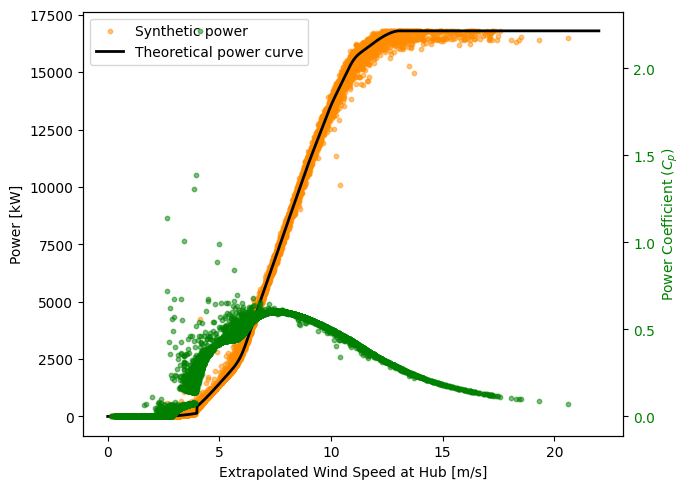

In [170]:
plot_power_curve(data=df_lean, power_curve=power_curve)

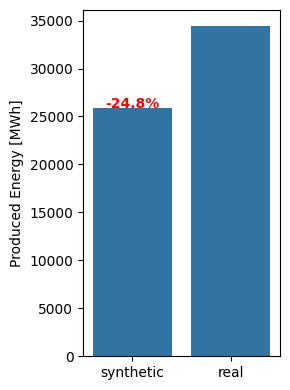

In [180]:
plot_sum_produced(data=sum_produced)

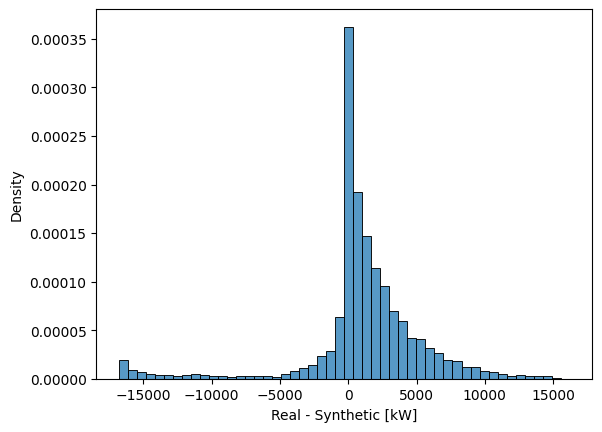

In [172]:
plot_error_distribution(data=bias)

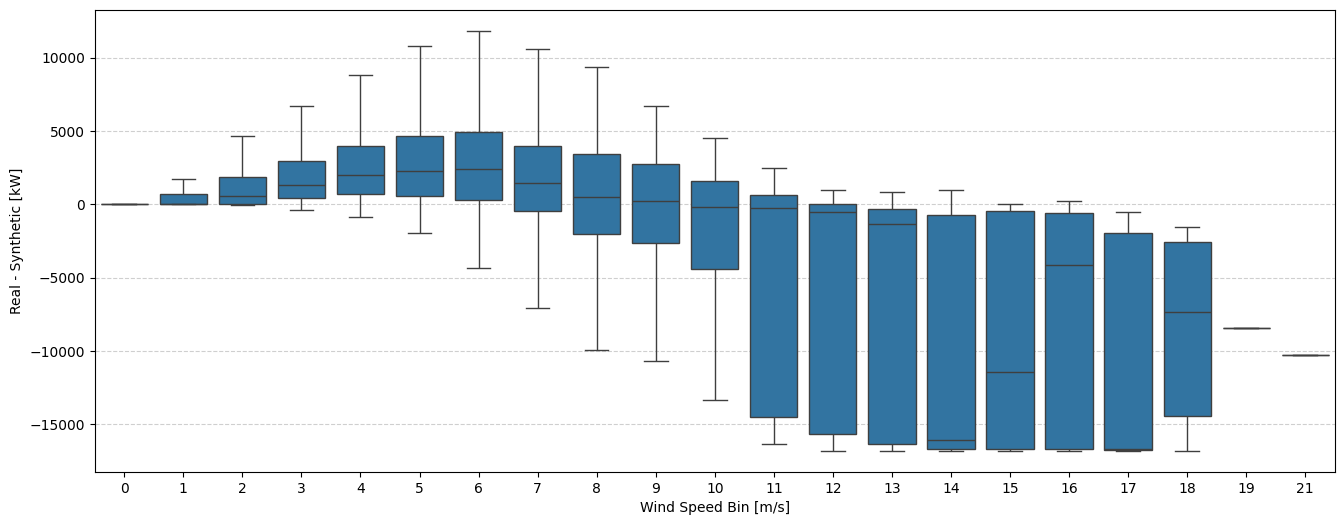

In [173]:
plot_wind_bin_errors(data=df_lean)

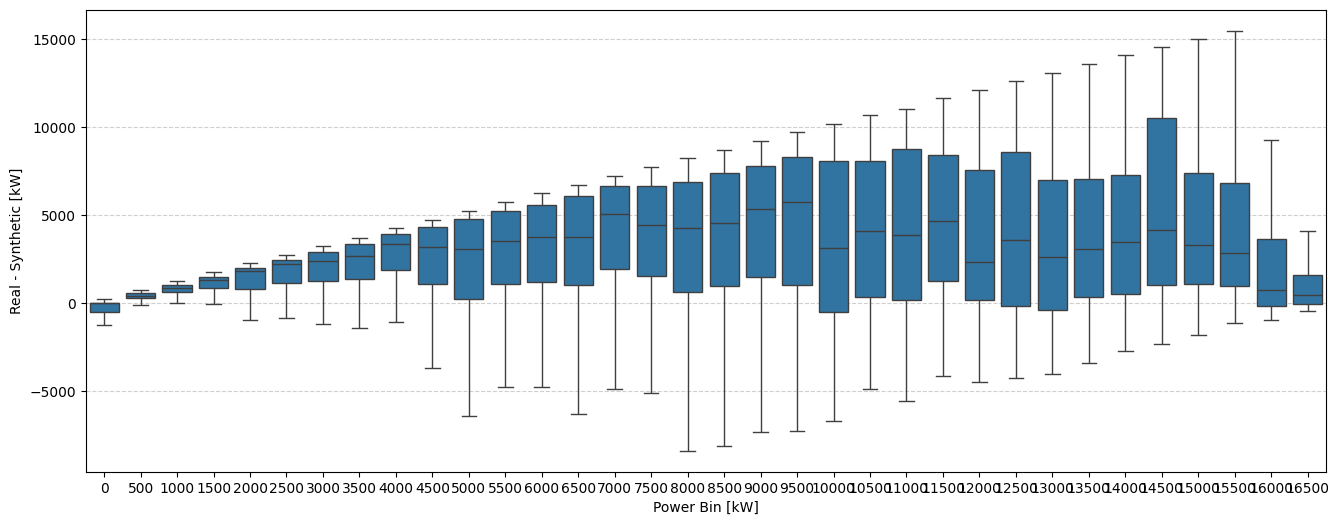

In [174]:
plot_power_bin_errors(data=df_lean)

In [175]:
print(f'R^2: {round(r_2 * 100, 2)} %')
print(f'MAE: {round(mae, 2) * 100} %')

R^2: 12.8 %
MAE: 17.0 %
